## Granular Ad Analysis Continued

Using data from the Unique Ad dataset, we will be taking the "fact-checking" grade and applying it to the 2016 Presidential ad dataset. A fact-check score is assigned to each unique advertisement per the Political Ad Archive:

"number of fact or source checks from our partner organizations for this particular ad. For example, the claim that Donald Trump once supported impeaching former President George W. Bush, contained in this ad sponsored by Our Principles PAC, a super PAC opposing Trump, was fact checked by PolitiFact, which rated it as "True." The PolitiFact story is embedded on the Political TV Ad Archive page displaying the ad."

The following steps will be taken to quantify whether or not ads being factual actually matters:

* Apply the unique ad fact-check grade to each airing from the master ad dataset
* Create a new column in the master ad dataframe 'fc_min' for "fact-check-minutes" by multiplying the fact-check grade by the ad length in seconds and dividing by 60

We will then run some comparisons based on the fact-check score of the ads, we will start with:

* box and whisker plot of reference count for each candidate
* fact-check minutes as a function of time total and for each candidate

In [3]:
## Import and load data
%matplotlib inline
import pickle
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [4]:
## for plots I'll be using the FiveThirtyEight stylesheet
plt.style.use('fivethirtyeight')

## loading data from tv ad .csv
df = pd.read_pickle('data/pres_sorted_with_sponsors_and_party_and_fact_check.pkl')
df_unique = pd.read_csv('data/unique_ads_aired.csv')

In [5]:
## get a picture of each dataframe
df.head(3)

,id,wp_identifier,network,location,program,program_type,start_time,end_time,archive_id,embed_url,...,day_of_week,metro_area,state,subject_count,hour_aired,sponsor_class,party,date_aired,r_c,fc_min
start_time,,,,,,,,,,,,,,,,,,,,,
2016-08-01 01:19:59,261456,6035,FOXNEWSW,"San Francisco-Oakland-San Jose, CA",On the Record With Greta Van Susteren,news,2016-08-01 01:19:59,2016-08-01 01:21:04,PolAd_HillaryClinton_4drmd,https://archive.org/embed/PolAd_HillaryClinton...,...,Monday,San Francisco-Oakland-San Jose,National,1.0,1,R_PAC,R,2016-08-01,0,0.0
2016-08-01 06:20:04,261450,6035,FOXNEWSW,"San Francisco-Oakland-San Jose, CA",Fox News Sunday With Chris Wallace,news,2016-08-01 06:20:04,2016-08-01 06:21:09,PolAd_HillaryClinton_4drmd,https://archive.org/embed/PolAd_HillaryClinton...,...,Monday,San Francisco-Oakland-San Jose,National,1.0,6,R_PAC,R,2016-08-01,0,0.0
2016-08-01 08:39:49,48222,4176,WCAU,"Philadelphia, PA",NBC10 News Today at 430am,news,2016-08-01 08:39:49,2016-08-01 08:40:21,PolAd_DonaldTrump_99k4w,https://archive.org/embed/PolAd_DonaldTrump_99k4w,...,Monday,Philadelphia,PA,4.0,8,Clinton,D,2016-08-01,0,0.0


In [6]:
df_unique.head()

,wp_identifier,archive_id,embed_url,sponsors,sponsor_types,subjects,candidates,type,race,cycle,message,air_count,reference_count,market_count,transcript,date_ingested
0,8403,PolAd_CatherineCortezMasto_jbah8,https://archive.org/embed/PolAd_CatherineCorte...,Catherine Cortez Masto for Senate,Candidate Committee,"Candidate Biography, Bipartisanship, Criminal ...",Catherine Cortez Masto,campaign,NVS2,2016.0,pro,185,0,1,NaN,2016/11/17 5:03:54 UTC
1,8404,PolAd_DonaldTrump_kc0en,https://archive.org/embed/PolAd_DonaldTrump_kc0en,Hillary for America,Multiple,"Nuclear, Candidate Biography, Military, Foreig...",Donald Trump,campaign,PRES,2016.0,con,139,0,1,NaN,2016/11/17 5:02:52 UTC
2,8358,PolAd_DonaldTrump_ncck5,https://archive.org/embed/PolAd_DonaldTrump_ncck5,Hillary for America,Multiple,"Bankruptcy, Candidate Biography, Workers",Donald Trump,campaign,PRES,2016.0,con,195,0,2,NaN,2016/11/14 10:44:42 UTC
3,8359,PolAd_Guns_gv0de,https://archive.org/embed/PolAd_Guns_gv0de,National Rifle Assn,PAC,Guns,NaN,campaign,NaN,NaN,unknown,87,0,3,NaN,2016/11/14 10:44:15 UTC
4,8361,PolAd_Guns_Veterans_Military_z2bvd,https://archive.org/embed/PolAd_Guns_Veterans_...,National Rifle Assn,PAC,"Guns, Veterans, Military",NaN,campaign,NaN,NaN,unknown,54,0,3,NaN,2016/11/14 10:43:51 UTC


#### Looking at reference_count

Running the pandas 'describe' command shows us that there are many ads and very few have any fact check references as evidenced by the mean of 0.0468 references per unique ad.

We can see that when we filter for only ads that contain at least one fact check reference, there are 120 unique ads that were fact-checked, amounting to 4.22% of all unique ads.

In [7]:
df_unique.reference_count.describe()

count    2842.000000
mean        0.046798
std         0.237889
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: reference_count, dtype: float64

In [8]:
fc_nonzero = df_unique[df_unique['reference_count'] > 0]
print(fc_nonzero.describe())
print(100*120/2842)

       wp_identifier   cycle    air_count  reference_count  market_count
count     120.000000   114.0   120.000000       120.000000    120.000000
mean     3336.800000  2016.0   461.458333         1.108333      3.541667
std      2173.849564     0.0   752.748810         0.405753      4.226558
min       240.000000  2016.0     0.000000         1.000000      0.000000
25%      1694.250000     NaN     0.000000         1.000000      1.000000
50%      3109.500000     NaN   150.000000         1.000000      2.000000
75%      5058.250000     NaN   498.000000         1.000000      5.000000
max      8278.000000  2016.0  3902.000000         4.000000     21.000000
4.2223786066150595


C:\Users\Gutwein\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [9]:
print(df_unique.index)
print(len(df_unique))

RangeIndex(start=0, stop=2842, step=1)
2842


In [ ]:
def match_ad(ad_id):
    for row in range(len(df_unique)):
        if ad_id == df_unique['archive_id'][row]:
            return df_unique['reference_count'][row]

df['r_c'] = df['archive_id'].map(match_ad)

In [10]:
df['r_c'].head()

start_time
2016-08-01 01:19:59    0
2016-08-01 06:20:04    0
2016-08-01 08:39:49    0
2016-08-01 08:48:14    0
2016-08-01 09:09:45    0
Name: r_c, dtype: int64

In [ ]:
df['fc_min'] = df['r_c'] * df['ad_length']

In [ ]:
df.to_pickle('./data/pres_sorted_with_sponsors_and_party_and_fact_check.pkl')

In [11]:
## group by Party
df_party = df.groupby('party')
print(df_party.head())

                         id  wp_identifier   network  \
start_time                                             
2016-08-01 01:19:59  261456           6035  FOXNEWSW   
2016-08-01 06:20:04  261450           6035  FOXNEWSW   
2016-08-01 08:39:49   48222           4176      WCAU   
2016-08-01 08:48:14   48395           4176       KYW   
2016-08-01 09:09:45  378441           7459    MSNBCW   
2016-08-01 09:24:05   48394           4176      WCAU   
2016-08-01 09:39:09  378448           7459    MSNBCW   
2016-08-01 10:26:51  261457           6035    MSNBCW   
2016-08-01 10:29:58   48393           4176      WTXF   
2016-08-01 12:44:19   48390           4176      WTXF   
2016-08-06 05:59:10  247992           5742       FBC   
2016-08-09 21:28:37   38524           4722  FOXNEWSW   
2016-08-18 15:19:07  262929           6208    LINKTV   
2016-08-18 19:18:56  262928           6208      KCSM   
2016-08-18 22:19:07  262927           6208    LINKTV   

                                               

C:\Users\Gutwein\Anaconda3\lib\site-packages\pandas\tools\plotting.py:3082: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  rot=rot, grid=grid, **kwds)


OrderedDict([('D',
              {'boxes': [<matplotlib.lines.Line2D at 0x1a9709436a0>],
               'caps': [<matplotlib.lines.Line2D at 0x1a97093b128>,
               'fliers': [<matplotlib.lines.Line2D at 0x1a970925f98>],
               'means': [],
               'medians': [<matplotlib.lines.Line2D at 0x1a97096d908>],
               'whiskers': [<matplotlib.lines.Line2D at 0x1a970977fd0>,
                <matplotlib.lines.Line2D at 0x1a97096ae80>]}),
             ('I',
              {'boxes': [<matplotlib.lines.Line2D at 0x1a97071efd0>],
               'caps': [<matplotlib.lines.Line2D at 0x1a970984be0>,
               'fliers': [<matplotlib.lines.Line2D at 0x1a9709e6da0>],
               'means': [],
               'medians': [<matplotlib.lines.Line2D at 0x1a9709e6550>],
               'whiskers': [<matplotlib.lines.Line2D at 0x1a970710630>,
                <matplotlib.lines.Line2D at 0x1a970708b70>]}),
             ('R',
              {'boxes': [<matplotlib.lines.Line2D at 0x

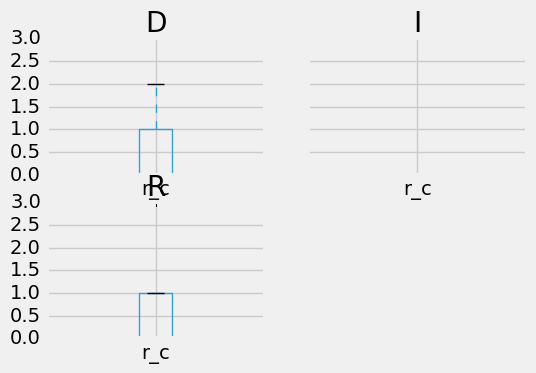

In [12]:
## box-and-whisker plot
df_party.boxplot(column='r_c')

In [13]:
## group by party, date -- run sum
df_party_date = df.groupby(['party', 'date_aired']).sum()
df_party_date

id  wp_identifier      cycle  ad_length  \
party date_aired                                                   
D     2016-08-01    1061749          91439    44352.0      726.0   
      2016-08-02    3828755         340947   163296.0     2609.0   
      2016-08-03    5049783         436756   205632.0     3467.0   
      2016-08-04    2663787         276632   127008.0     1961.0   
      2016-08-05    3189015         340919   155232.0     2347.0   
      2016-08-06    4160539         458320   201600.0     3064.0   
      2016-08-07    1997083         185654    80640.0     1441.0   
      2016-08-08   10915881        1151545   497952.0     8249.0   
      2016-08-09   16141882        1690018   741888.0    12463.0   
      2016-08-10   17385168        1931642   840672.0    13567.0   
      2016-08-11   15642993        1773510   764064.0    12130.0   
      2016-08-12   13822376        1517653   661248.0    11018.0   
      2016-08-13    7786030         840017   368928.0     6139.0   
      2016-08-14    9815660        1095019   473760.0     8014.0   
      2016-08-15   16290085        1784571   772128.0    12724.0   
      2016-08-16   11821763        1282156   552384.0     9214.0   
      2016-08-17    7761074         838736   360864.0     5842.0   
      2016-08-18    8551248         889593   383040.0     6359.0   
      2016-08-19   11029949        1046900   443520.0     7567.0   
      2016-08-20    4684952         525533   225792.0     4045.0   
      2016-08-21    6380485         715820   306432.0     5534.0   
      2016-08-22    8681675        1071779   453600.0     8426.0   
      2016-08-23   19246102        2060383   862848.0    14147.0   
      2016-08-24   18175624        2098776   883008.0    13706.0   
      2016-08-25    9444180        2048303   816480.0    13995.0   
      2016-08-26    7526105        2119135   824544.0    14351.0   
      2016-08-27    2955330         884999   344736.0     5370.0   
      2016-08-28    3746870        1049415   407232.0     6373.0   
      2016-08-29    7773404        2060851   802368.0    12141.0   
      2016-08-30    6916248        2446229   943488.0    14140.0   
...                     ...            ...        ...        ...   
R     2016-10-10   73146006        1558430   451584.0     6741.0   
      2016-10-11  130491536        2805695   800352.0    11916.0   
      2016-10-12  161916853        3623912  1046304.0    15570.0   
      2016-10-13  176585167        3752664  1086624.0    16870.0   
      2016-10-14  137659310        2506037   713664.0    11430.0   
      2016-10-15  107338444        1785590   508032.0     8190.0   
      2016-10-16   89955318        1535444   443520.0     6739.0   
      2016-10-17   99670448        1739942   495936.0     7470.0   
      2016-10-18  115319144        2021456   572544.0     8577.0   
      2016-10-19  232603679        4141757  1126944.0    16822.0   
      2016-10-20  241251288        4392935  1183392.0    17611.0   
      2016-10-21  252814120        4621683  1243872.0    18461.0   
      2016-10-22  147807045        2724282   729792.0    11113.0   
      2016-10-23  139612391        2580655   687456.0    10666.0   
      2016-10-24  244443086        4435056  1193472.0    17734.0   
      2016-10-25  259972359        4737400  1274112.0    19009.0   
      2016-10-26  260456031        4900845  1318464.0    19728.0   
      2016-10-27  274313584        5125147  1372896.0    21496.0   
      2016-10-28  254131918        4713961  1266048.0    19089.0   
      2016-10-29  175560217        3187251   854784.0    13406.0   
      2016-10-30  171069137        3125751   828576.0    12254.0   
      2016-10-31  269721072        4843820  1322496.0    19616.0   
      2016-11-01  357087627        6414438  1729728.0    25810.0   
      2016-11-02  381915819        6968420  1824480.0    27227.0   
      2016-11-03  474541866        8386340  2203488.0    33468.0   
      2016-11-04  528017018        9412789  2429280.0    38194.0   
      2016-11

In [ ]:
## pivot for time series plot
df_party_date.reset_index(inplace=True)
df_party_date_piv = df_party_date.pivot(index='date_aired', columns='party', values='fc_min')
print(df_party_date_piv.head())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = df_party_date_piv.plot(ax=ax)

# Add some more Labeling
ax.legend(loc="upper left", fontsize=16)
plt.title("Fact Checked Minutes of Ad Airtime",  y=1.01, size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Ad Air Time * Fact Check Sources / Per Ad", size=18)

# Axis Sizes and format
plt.tick_params(labelsize=10)

#### Fact Checked Ads in the Presidential Campaign

There were a total of 245 unique ads run in the 2016 presidential campaign. Of these 245, 20 of them were fact-checked, resulting in 8.16% of unique advertisements were fact checked.

There were a total of 83,349 advertisements aired curing the 2016 presidential campaign. Of these 83,349, 24,971 aired advertisements were fact-checked, resulting in approximately 30% of ads.

#### by Party



In [ ]:
## Let's re-run the stats
print(len(df['archive_id'].unique()))
print(len(df[df['r_c'] > 0]['archive_id'].unique()))
df_party.agg({'ad_length':sum, 'fc_min':sum})

In [ ]:
print(100*20/245)

In [ ]:
tot_fc = len(df[df['r_c'] > 0])
tot = len(df)
per_fc = 100 * tot_fc / tot
print(tot_fc, tot, per_fc)

In [ ]:
tot_dem_fc = len(df[(df['party'] == 'D') & (df['r_c'] > 0)])
tot_dem = len(df[df['party'] == 'D'])
per_dem = 100 * tot_dem_fc / tot_dem
tot_rep_fc = len(df[(df['party'] == 'R') & (df['r_c'] > 0)])
tot_rep = len(df[df['party'] == 'R'])
per_rep = 100 * tot_rep_fc / tot_rep
print(tot_dem_fc, tot_dem, per_dem)
print(tot_rep_fc, tot_rep, per_rep)

In [ ]:
fact_check_tots = [tot, tot_fc, per_fc]
dem_fact_check_tots = [tot_dem, tot_dem_fc, per_dem]
rep_fact_check_tots = [tot_rep, tot_rep_fc, per_rep]
df_fc = pd.DataFrame([fact_check_tots, dem_fact_check_tots, rep_fact_check_tots])
df_fc.index = ['Total', 'Hillary Clinton', 'Donald Trump']
df_fc.columns = ['Total Ads Aired', 'Fact-Checked Ads Aired', '% Fact Checked']
df_fc

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = df_fc.plot(ax=ax, kind='bar')

# Add some more Labeling
ax.legend(loc="upper left", fontsize=16)
plt.title("Fact Checked Ads vs. Total Ads",  y=1.01, size=20)
plt.ylabel("Total Ads / Percentage", size=18)

# Axis Sizes and format
plt.tick_params(labelsize=14)

In [ ]:
## try grouping by date

time_aired_bydate = df['date_aired'].map(sum(df['ad_length']))
f_c_minutes_bydate = df['date_aired'].map(sum(df['r_c']))
print(time_aired_bydate.head(10))
print(f_c_minutes_bydate.head(10))

fig, ax = plt.subplots(figsize=(15, 5))
time_aired_bydate.fillna(0).plot()
f_c_minutes_bydate.fillna(0).plot()

plt.title("Total Ads Aired and Fact-Check Seconds")
plt.ylabel("Total Air Time (seconds)")

plt.savefig('granular_pics/fact_check_1.png')